In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from copy import deepcopy
from scipy.spatial.transform import Rotation as ScipyRot
import matplotlib.pyplot as plt
import time as systemtime

# SUPPORTING FUNCTIONS

In [ ]:
def function_S(input):
    # input should be array
    # output array
    flattened_input = input.flatten()
    output = [[0,           -flattened_input[2],    flattened_input[1]],
              [flattened_input[2],  0,              -flattened_input[0]],
              [-flattened_input[1], flattened_input[0],     0]]
    return np.array(output)

In [ ]:
def rodrigues_formula(quaternion):
    '''
    quaternion -> R_tilde_bar
    input: [w,x,y,z]
    output R_tile_bar (rotation matrix)
    From page6
    '''
    return np.eye(3) + 2*np.matmul(function_S(quaternion[1:]), (quaternion[0]*np.eye(3) + function_S(quaternion[1:])))


In [ ]:
def function_A(omega):
    A11 = function_S(-omega)
    A12 = np.zeros((3,3))
    A21 = np.zeros((3,3))
    A22 = function_S(-omega)
    return np.vstack((np.hstack((A11, A12)), np.hstack((A21, A22))))


In [ ]:
def function_Pi(input):
    '''
    Pi_x := I_3 - xx^T
    input: array
    output P_x
    '''
    return np.eye(3) - np.matmul(input, np.transpose(input))

In [ ]:
def function_d(input_rot, input_p, input_z, with_noise):
    '''
    calculate d_i(t) := R^T(t)(p(t) - z_i)/|p(t)-z_i|
    '''
    norm = (input_p - input_z)/np.linalg.norm(input_p - input_z)
    dir = np.matmul(np.transpose(input_rot), norm)
    if with_noise:
        '''
        calculate noisy d = sign(d_{i,3}) / demon (d_{i,1}/d_{i,3} + n_{n,1}, d_{i,2}/d_{i,3} + n_{i,2}, 1).T
        demon = sqrt((d_{i,1}/d_{i,3} + n_{n,1})^2 + (d_{i,2}/d_{i,3} + n_{i,2})^2 + 1)
        '''
        dir = dir.flatten()
        n_1 = np.random.uniform(-0.005, 0.005, 1)[0]
        n_2 = np.random.uniform(-0.005, 0.005, 1)[0]
        d1_d3 = dir[0]/dir[2] + n_1
        d2_d3 = dir[1]/dir[2] + n_2
        demon = np.sqrt(d1_d3**2 + d2_d3**2 + 1)
        dir = (np.sign(dir[2])/ demon) * np.array([[d1_d3, d2_d3, 1]]).T
    return dir

In [ ]:
def function_C(input_R, input_R_hat, input_p, input_z, with_noise, num_landmarks):
    for landmark_idx in range(num_landmarks):
        # S(R_hat.T x z)
        first = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise))
        second = function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
        final = -np.matmul(first, second)
        C_landmark = np.hstack((final, first))
        if landmark_idx == 0:
            output_C = C_landmark
        else:
            output_C = np.vstack((output_C, C_landmark))
    return output_C

In [ ]:
def add_bar(input_rot, input_p):
    return np.matmul(np.transpose(input_rot), input_p)

In [ ]:
def remove_bar(input_rot, input_p_bar):
    return np.matmul(np.linalg.inv(np.transpose(input_rot)), input_p_bar)

# SIMULATION

In [ ]:
def plot_output(which_eq, noise, save_graph):
    if noise:
        name = "_with_noise.png"
    else:
        name = "_without_noise.png"
    figure = plt.subplot()

    plot_est_p = []
    plot_act_p = []
    for t, rotation, p_bar_hat in zip(sol.t, sol_est_R, sol_est_p_bar):
        p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
        p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(rotation).reshape((3,3)))), p_bar_hat)
        plot_est_p.append(p_temp.tolist())
        plot_act_p.append(p.tolist())

    plt.plot(sol.t, np.array(plot_act_p)-np.array(plot_est_p), label=["x", "y", "z"])
    plt.xlim(0)
    plt.ylim(-0.5, 0.5)
    plt.legend(loc="upper right")
    plt.title("pose")
    plt.grid()
    plt.minorticks_on()
    plt.savefig("/home/annika/ITRL/kth_thesis/eq" + str(which_eq) + "_pose" + name, format='png', dpi=300)

    plt.show()

    plot_err_lambda_bar = []
    plot_act_lambda_bar = []
    plot_est_lambda_bar = []
    for idx, (t, est_rotation, rotation) in enumerate(zip(sol.t, sol_est_R, sol_R)):
        err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
        est = ScipyRot.from_matrix(np.array(est_rotation).reshape((3,3)))
        act = ScipyRot.from_matrix(np.array(rotation).reshape((3,3)))
        err = ScipyRot.from_matrix(err)
        err = err.as_quat().tolist()
        est = est.as_quat().tolist()
        act = act.as_quat().tolist()
        plot_err_lambda_bar.append(err)
        plot_est_lambda_bar.append(est)
        plot_act_lambda_bar.append(act)

    plt.plot(sol.t, np.array(plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"])
    plt.xlim(0)
    plt.ylim(-0.1, 0.1)
    plt.legend(loc="upper right")
    plt.title("orientation")
    plt.grid()
    plt.minorticks_on()
    plt.savefig("/home/annika/ITRL/kth_thesis/eq" + str(which_eq) + "_orientation" + name, format='png', dpi=300)
    plt.show()

In [ ]:
def data_to_csv(noise):
    import pandas as pd
    plot_est_p = []
    plot_act_p = []
    for t, rotation, p_bar_hat in zip(sol.t, sol_est_R, sol_est_p_bar):
        p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
        p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(rotation).reshape((3,3)))), p_bar_hat)
        plot_est_p.append(p_temp.tolist())
        plot_act_p.append(p.tolist())

    plot_err_lambda_bar = []
    plot_act_lambda_bar = []
    plot_est_lambda_bar = []
    for idx, (t, est_rotation, rotation) in enumerate(zip(sol.t, sol_est_R, sol_R)):
        err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
        est = ScipyRot.from_matrix(np.array(est_rotation).reshape((3,3)))
        act = ScipyRot.from_matrix(np.array(rotation).reshape((3,3)))
        err = ScipyRot.from_matrix(err)
        err = err.as_quat().tolist()
        est = est.as_quat().tolist()
        act = act.as_quat().tolist()
        plot_err_lambda_bar.append(err)
        plot_est_lambda_bar.append(est)
        plot_act_lambda_bar.append(act)

    # Create a DataFrame from the lists
    df = pd.DataFrame({'Actual p x': np.array(plot_act_p).T[0], 
                    'Actual p y': np.array(plot_act_p).T[1], 
                    'Actual p z': np.array(plot_act_p).T[2], 
                    
                    'Estimate P x': np.array(plot_est_p).T[0], 
                    'Estimate P y': np.array(plot_est_p).T[1], 
                    'Estimate P z': np.array(plot_est_p).T[2],

                    'Estimate P bar x': sol_est_p_bar.T[0], 
                    'Estimate P bar y': sol_est_p_bar.T[1], 
                    'Estimate P bar z': sol_est_p_bar.T[2], 
                    
                    'Error lambda bar x': np.array(plot_err_lambda_bar).T[0], 
                    'Error lambda bar y': np.array(plot_err_lambda_bar).T[1], 
                    'Error lambda bar z': np.array(plot_err_lambda_bar).T[2], 
                    'Error lambda bar w': np.array(plot_err_lambda_bar).T[3], 

                    'estimate lambda x': np.array(plot_est_lambda_bar).T[0],
                    'estimate lambda y': np.array(plot_est_lambda_bar).T[1],
                    'estimate lambda z': np.array(plot_est_lambda_bar).T[2],
                    'estimate lambda w': np.array(plot_est_lambda_bar).T[3],
                    
                    'Actual lambda x': np.array(plot_act_lambda_bar).T[0],
                    'Actual lambda y': np.array(plot_act_lambda_bar).T[1],
                    'Actual lambda z': np.array(plot_act_lambda_bar).T[2],
                    'Actual lambda w': np.array(plot_act_lambda_bar).T[3],
                    
                    'time': sol.t.tolist()})

    if noise:
        # Write the DataFrame to a text file, without the indices
        df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_with_noise.txt', sep='\t', index=False, header=False)
    else:
        # Write the DataFrame to a text file, without the indices
        df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_without_noise.txt', sep='\t', index=False, header=False)


In [ ]:
def observer_equations(input_omega, input_p_bar_hat, input_R, input_v, num_landmarks, input_q, input_R_hat, input_z, input_p, with_noise, input_k, input_P, which_eq):
    if which_eq == 0:
        
        # omega
        first_upper = input_omega
        
        # -S(omega)p_bat_hat + v_bar
        first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)
        first_part = np.vstack((first_upper, first_lower))
        # omega_hat second part upper
        if not input_z.any() == None:
            final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
            for landmark_idx in range(num_landmarks):
                #q*S(R_hat.T z)
                first = input_q[landmark_idx]*function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
                #Pi_d
                second = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)) #TODO
                #(p_bar_hat - R_hat.Tz)
                third = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
                final += np.matmul(first, np.matmul(second, third))

            # omega_hat second part lower
            final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
            for landmark_idx in range(num_landmarks):
                #q*Pi_d
                first = input_q[landmark_idx]*function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)) #TODO
                #(p_bar_hat - R_hat.T x z)
                second = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
                final2 += np.matmul(first, second)
            second_part = np.vstack((final, final2))
            #kP[]
            #full second part 
            second_part = input_k*np.matmul(input_P, second_part)

            # Final
            output_omega_hat_p_bar_hat_dot = first_part - second_part
        else:
            output_omega_hat_p_bar_hat_dot = first_part
        
    elif which_eq == 1:
        ### First part ###
        ###TODO: this observer is for lamnda and p?? 
        # omega hat
        first_upper = input_omega

        # -S(w)p_bar_hat + v_bar
        first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)

        # first part final
        first_part = np.vstack((first_upper, first_lower))

        ### Second part ###
        # input_p_bar = add_bar(input_R, input_p)
        input_p_hat = np.matmul(np.linalg.inv(np.transpose(input_R_hat)), input_p_bar_hat)
        # input_p_hat = remove_bar(input_R_hat, input_p_bar_hat)
        # omega hat
        final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            Pi_d_hat = function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise))
            # q |p_hat - z| S(d_i_hat) R_hat.T
            first = input_q[landmark_idx]*np.linalg.norm(input_p_hat - np.transpose(input_z[landmark_idx]))*np.matmul(function_S(function_d(input_R_hat, input_p_hat, input_z, with_noise)), np.transpose(input_R_hat))
            # |p_hat - z| Pi(d_i_hat) d_i
            second = np.linalg.norm(input_p_hat - np.transpose(input_z[landmark_idx]))*np.matmul(Pi_d_hat, function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise))
            # Pi(d_i_hat) (R.T z - R_hat.T p_bar_hat)
            third = np.matmul(Pi_d_hat, (np.matmul(np.transpose(input_R), np.transpose(input_z[landmark_idx])) - np.matmul(np.transpose(input_R_hat), input_p_bar_hat)))
            final += np.matmul(first, second + third)
        
        final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            # q Pi(d_i_hat) R_hat.T
            first = input_q[landmark_idx]*np.matmul(function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise)), np.transpose(input_R_hat))
            # |p_hat - z| Pi(d_i_hat) d_i
            second = np.linalg.norm(input_p_hat - np.transpose(input_z[landmark_idx]))*np.matmul(function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise)), function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise))
            # Pi(d_i_hat) (R.T z - R_hat.T p_bar_hat)
            third = np.matmul(function_Pi(function_d(input_R_hat, input_p_hat, np.transpose(input_z[landmark_idx]), with_noise)), (np.matmul(np.transpose(input_R), np.transpose(input_z[landmark_idx])) - np.matmul(np.transpose(input_R_hat), input_p_bar_hat)))
            final2 += np.matmul(first, second + third)

        second_part = np.vstack((final, final2))
        second_part = input_k*np.matmul(input_P, second_part)

        output_omega_hat_p_bar_hat_dot = first_part + second_part

    elif which_eq == 2:
        ### First part ###
        # omega hat
        first_upper = input_omega

        # -S(w)p_bar_hat + v_bar
        first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)

        # first part final
        first_part = np.vstack((first_upper, first_lower))

        ### Second part ###
        # omega hat
        final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            d_bar_hat = (input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))/ np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
            Pi_d_bar_hat = function_Pi(d_bar_hat)
            # q S(R_hat.T z) Pi_d_bar_hat 
            first = input_q[landmark_idx]*np.matmul(function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))), Pi_d_bar_hat)
            # |p_bar_hat - R_hat.T z| di
            second = np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))*function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)
            # (R_hat.T z - p_bar_hat)
            third = np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])) - input_p_bar_hat
            final += np.matmul(first, (second + third))

        final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
        for landmark_idx in range(num_landmarks):
            d_bar_hat = (input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))/ np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
            Pi_d_bar_hat = function_Pi(d_bar_hat)
            # q Pi_d_bar_hat
            first = input_q[landmark_idx]*Pi_d_bar_hat
            # |p_bar_hat - R_hat.T z| di
            second = np.linalg.norm(input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))) * function_d(input_R, input_p, np.transpose(input_z[landmark_idx]), with_noise)
            # (R_hat.T z - p_bar_hat)
            third = np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])) - input_p_bar_hat
            final2 += np.matmul(first, (second + third))

        second_part = np.vstack((final, final2))
        second_part = input_k*np.matmul(input_P, second_part)

        output_omega_hat_p_bar_hat_dot = first_part + second_part


    return output_omega_hat_p_bar_hat_dot

In [ ]:
def dynamics(t, y, input_k, input_z, input_q, input_Q, input_V, with_noise, num_landmarks, which_eq):
    # pose
    input_p = np.transpose(np.array([[2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10]]))

    ####################################
    ########### Measurements ###########
    if with_noise:
        b_v = np.random.normal(0, 0.1, 1)
        b_omega = np.random.normal(0, 0.01, 1)
        # velocity
        input_v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0]])) + b_v
        # angular velocity
        input_omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]])) + b_omega
    else:
        # velocity
        input_v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0]]))
        # angular velocity
        input_omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]]))
    ########### Measurements ###########
    ####################################

    # (Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten())
    Rot_flat, Rot_hat_flat, p_bar_hat_flat, input_P_flat = np.split(y, [9, 18, 21])
    input_R = Rot_flat.reshape((3,3))
    input_R_hat = Rot_hat_flat.reshape((3,3))
    input_p_bar_hat = p_bar_hat_flat.reshape((3,1))
    input_P = input_P_flat.reshape((6,6))

    input_A = function_A(input_omega)
    if not input_z.any() == None:
        input_C = function_C(input_R, input_R_hat, input_p, input_z, with_noise, num_landmarks)

    ####################################
    ############# Observer #############
    output_omega_hat_p_bar_hat_dot = observer_equations(input_omega, input_p_bar_hat, input_R, input_v, num_landmarks, input_q, input_R_hat, input_z, input_p, with_noise, input_k, input_P, which_eq)
    ############# Observer #############
    ####################################
    if not input_z.any() == None:
        output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V
    else:
        output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) + input_V

    omega_hat = output_omega_hat_p_bar_hat_dot[0:3]
    output_R_hat_dot = np.matmul(input_R_hat, function_S(omega_hat))
    p_bar_hat_dot = output_omega_hat_p_bar_hat_dot[3:]
    output_R = np.matmul(input_R, function_S(input_omega))

    # (Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten())
    return np.concatenate((output_R.flatten(), output_R_hat_dot.flatten(), p_bar_hat_dot.flatten(), output_P_dot.flatten()))


In [ ]:
def rk45_step(t, y, dt, args, tol, adaptive):
    a2, a3, a4, a5, a6 = 1/5, 3/10, 4/5, 8/9, 1
    b21 = 1/5
    b31, b32 = 3/40, 9/40
    b41, b42, b43 = 44/45, -56/15, 32/9
    b51, b52, b53, b54 = 19372/6561, -25360/2187, 64448/6561, -212/729
    b61, b62, b63, b64, b65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
    c1, c2, c3, c4, c5, c6 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

    c1_4, c3_4, c4_4, c5_4, c6_4 = 5179/57600, 7571/16695, 393/640, -92097/339200, 187/2100
    # Runge-Kutta stages
    k1 = dynamics(t, y, *args)
    k2 = dynamics(t + a2*dt, y + dt*b21*k1, *args)
    k3 = dynamics(t + a3*dt, y + dt*(b31*k1 + b32*k2), *args)
    k4 = dynamics(t + a4*dt, y + dt*(b41*k1 + b42*k2 + b43*k3), *args)
    k5 = dynamics(t + a5*dt, y + dt*(b51*k1 + b52*k2 + b53*k3 + b54*k4), *args)
    k6 = dynamics(t + a6*dt, y + dt*(b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5), *args)

    # Update step
    y_next = y + dt*(c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6)

    if adaptive:
        y_next_4 = y + dt * (c1_4*k1 + c3_4*k3 + c4_4*k4 + c5_4*k5 + c6_4*k6)

        error = np.abs(y_next - y_next_4)
        error_norm = np.linalg.norm(error)
        safety_factor = 0.9
        min_scale_factor = 0.2
        max_scale_factor = 40.0
        if error_norm <= tol:
            success = True
            t = t+dt
            dt = dt * min(max_scale_factor, max(min_scale_factor, safety_factor * (tol / error_norm)**0.25))
        else:
            success = False
            dt = dt * max(min_scale_factor, safety_factor * (tol / error_norm)**0.25)
    else: 
        if np.isnan(y_next).any():
            success = False
        else:
            success = True
    return y_next, dt, success

In [ ]:
noise = False

which_eq = 0
plot_graph = True
save_graph = True
save_as_csv = False
time = (0, 100)
stepsize = 0.1
times = np.arange(*time, stepsize)
with_image_hz_sim = True
image_time = np.arange(*time, 1/20)
threshold_image = 0.0001
# tol = 1e-2 * 6#0.05
tol = 0.05
use_adaptive = True

######################################################
################# initialization #####################
######################################################
l = 3
k = 1
q = [10, 10, 10]
Q = np.diag(np.hstack([np.diag(q[0]*np.eye(3)), np.diag(q[1]*np.eye(3)), np.diag(q[2]*np.eye(3))]))
V = np.diag(np.hstack([np.diag(0.1*np.eye(3)), np.diag(np.eye(3))]))
# landmarks
z_appear = np.array([[[2.5, 2.5, 0]],
              [[5, 0, 0]],
              [[0, 0, 0]]])

Rot = np.eye(3)
## R_hat = R x R_tilde_bar
Lambda_bar_0 = np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0, 0]).T  # quaternion: w, x, y, z
Rot_hat = np.matmul(Rot, rodrigues_formula(Lambda_bar_0)) 
# p_hat = np.array([[1, 4, 7]], dtype=np.float64).T
p_hat = np.array([[-2, 4, 3]], dtype=np.float64).T
# p = np.array([[2.5, 0, 10]], dtype=np.float64).T
p_bar_hat = add_bar(Rot_hat, p_hat)
P_ricatti = np.diag(np.hstack([np.diag(np.eye(3)), np.diag(100*np.eye(3))]))
initial_state = np.concatenate((Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten()))

soly = []
solt = []
caltime = []
soly.append(initial_state)
dt = stepsize
current_time = 0
start_time = systemtime.time()
while current_time <= time[1]:
    if with_image_hz_sim:
        show_measurement = any(abs(current_time - t)/(current_time+1e-10) <= threshold_image for t in image_time)
        if show_measurement:
            print(current_time, '=================================' ,show_measurement)
            z = z_appear
        else:
            print(current_time, show_measurement)
            z = np.array([None])
    else:
        z = z_appear
    args = (k, z, q, Q, V, noise, l, which_eq)
    y_next, new_dt, success = rk45_step(current_time, soly[-1], dt, args, tol, use_adaptive)
    if use_adaptive:
        if success:
            soly.append(y_next)
            solt.append(current_time)
            end_time = systemtime.time()
            caltime.append(end_time - start_time)
            start_time = end_time
            if current_time >= time[1]:
                break
            current_time = current_time + dt  
            if current_time + new_dt < time[1]:
                dt = new_dt
            else:
                dt = time[1] - current_time
        else:
            dt = new_dt
    else:
        if success:
            soly.append(y_next)
            solt.append(current_time)
            end_time = systemtime.time()
            caltime.append(end_time - start_time)
            start_time = end_time
            current_time += dt
        else:
            print(current_time, len(soly))
            break


0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
0 ================================= True
4.618435101220246e-06 False
8.849262275733432e-06 False
8.543097638087372e-05 False
0.0007574733737808084 False
0.00418374529757993 False
0.015804825981392476 False
0.04481780595299649 False
0.10229967043023902 False
0.1979231116371052 False
0.3375009202464926 False
0.5229504141462946 False
0.7542478168986633 False
1.0304354192475902 False
1.345629730271505 False
1.6839493384339908 False
2.022280411723704 False
2.022280411

/tmp/ipykernel_23257/2965714267.py:39: RuntimeWarning: overflow encountered in matmul
  output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V
/tmp/ipykernel_23257/2965714267.py:44: RuntimeWarning: overflow encountered in matmul
  output_R_hat_dot = np.matmul(input_R_hat, function_S(omega_hat))
/tmp/ipykernel_23257/3715446314.py:5: RuntimeWarning: invalid value encountered in matmul
  second = function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
/tmp/ipykernel_23257/2531729835.py:15: RuntimeWarning: invalid value encountered in matmul
  first = input_q[landmark_idx]*function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
/tmp/ipykernel_23257/2531729835.py:19: RuntimeWarning: invalid value encountered in matmul
  third = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.tra

7.249650047138159 ================================= True
7.249654006826172 ================================= True
7.249658049144951 ================================= True
7.24966217699575 ================================= True
7.24966639331849 ================================= True
7.249670701114773 ================================= True
7.249675103466825 ================================= True
7.2496796035535045 ================================= True
7.249684204664235 ================================= True
7.249688910211501 ================================= True
7.2496937237423955 ================================= True
7.249698648949614 ================================= True
7.249703689682159 ================================= True
7.249708849956018 ================================= True
7.24971413396497 ================================= True
7.249719546091692 ================================= True
7.24972509091928 ================================= True
7.249730773243302 ===============

7.312513848227721 False
7.319797314527831 False
7.3271776733912 False
7.334632562729226 False
7.342144736104547 False
7.349700918866104 ================================= True
7.349700918866104 ================================= True
7.349700918866104 ================================= True
7.349700918866104 ================================= True
7.349700918866104 ================================= True
7.349700918866104 ================================= True
7.349700918866104 ================================= True
7.349700918866104 ================================= True
7.349700918866104 ================================= True
7.349700918866104 ================================= True
7.349801256840684 ================================= True
7.349891572992931 ================================= True
7.3499768886932335 ================================= True
7.350060225380746 ================================= True
7.350143558500361 ================================= True
7.350228272463638 ========

/tmp/ipykernel_23257/430355918.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  dt = dt * min(max_scale_factor, max(min_scale_factor, safety_factor * (tol / error_norm)**0.25))


In [ ]:
# Rtol=1e-7 #with noise, 1e-6
# Atol=1e-7 #with noise, 1e-6
# z = z_appear
# sol = solve_ivp(dynamics, time, initial_state, args=(k, z, q, Q, V, noise, l, which_eq), t_eval=np.arange(*(time), 1e-3), method="RK45", rtol=Rtol, atol=Atol)
# solution = np.transpose(np.array(sol.y))
# sol_t = sol.t

import pandas as pd
solution = pd.read_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_for_100s_step_1e-3_rtol_atol_1e-7.txt', header=None)
solution = np.transpose(solution.to_numpy().reshape((58,-1)))

sol_R = solution[:,:9]
sol_est_R = solution[:,9:18]
sol_est_p_bar = solution[:,18:21]
sol_P_ricatti = solution[:,21:57]
sol_t = solution[:,57]


In [ ]:
# import pandas as pd
# df = pd.DataFrame(np.vstack((sol.y, sol.t)).flatten())
# df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_for_100s_step_1e-3_rtol_atol_1e-7.txt', sep='\t', index=False, header=False)

In [ ]:
lim = 10
limo = 1

In [ ]:
# figure, ax = plt.subplots(1,4, figsize=(12, 4))

# plot_est_p = []
# plot_act_p = []
# for t, solution in zip(solt, soly):
#     own_sol_est_R = solution[9:18]
#     own_sol_est_p_bar = solution[18:21]
#     p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
#     p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(own_sol_est_R).reshape((3,3)))), own_sol_est_p_bar)
#     plot_est_p.append(p_temp.tolist())
#     plot_act_p.append(p.tolist())
# scipy_plot_est_p = []
# scipy_plot_act_p = []
# for t, rotation, p_bar_hat in zip(sol.t, sol_est_R, sol_est_p_bar):
#     p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
#     p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(rotation).reshape((3,3)))), p_bar_hat)
#     scipy_plot_est_p.append(p_temp.tolist())
#     scipy_plot_act_p.append(p.tolist())
# ax[0].plot(solt, np.array(plot_act_p)-np.array(plot_est_p), label=["x", "y", "z"])
# ax[0].legend(loc="upper right")
# ax[0].set_xlabel("own pose")
# ax[0].grid()
# ax[0].set_xlim(0)
# ax[0].minorticks_on()

# ax[1].plot(times[:len(soly)], np.array(scipy_plot_act_p)-np.array(scipy_plot_est_p), label=["x", "y", "z"])
# ax[1].legend(loc="upper right")
# ax[1].set_xlabel("scipy pose")
# ax[1].grid()
# ax[1].set_xlim(0)
# ax[1].minorticks_on()

# # ax[2].plot(times[:len(soly)], np.array(scipy_plot_act_p)-np.array(scipy_plot_est_p), label=["sx", "sy", "sz"])
# # ax[2].plot(times[:len(soly)], np.array(plot_act_p)-np.array(plot_est_p), linestyle=':',label=["ox", "oy", "oz"])
# # ax[2].set_xlabel("both pose")
# # ax[2].set_xlim(0)
# # ax[2].legend(loc="upper right")
# # ax[2].grid()
# # ax[2].minorticks_on()

# # ax[3].plot(times[:len(soly)], (np.array(scipy_plot_act_p)-np.array(scipy_plot_est_p))-(np.array(plot_act_p)-np.array(plot_est_p)), label=["x", "y", "z"])
# # ax[3].set_xlabel("scipy - own pose")
# # ax[3].set_xlim(0)
# # ax[3].set_ylim(-lim, lim)
# # ax[3].legend(loc="upper right")
# # ax[3].grid()
# # ax[3].minorticks_on()
# plt.show()

# figure, ax = plt.subplots(1,4, figsize=(12, 4))

# plot_err_lambda_bar = []
# plot_act_lambda_bar = []
# plot_est_lambda_bar = []
# for idx, (t, solution) in enumerate(zip(solt, soly)):
#     own_sol_R = solution[:9]
#     own_sol_est_R = solution[9:18]
#     err = np.matmul(np.linalg.inv(np.array(own_sol_est_R).reshape((3,3))), np.array(own_sol_R).reshape((3,3)))
#     est = ScipyRot.from_matrix(np.array(own_sol_est_R).reshape((3,3)))
#     act = ScipyRot.from_matrix(np.array(own_sol_R).reshape((3,3)))
#     err = ScipyRot.from_matrix(err)
#     err = err.as_quat().tolist()
#     est = est.as_quat().tolist()
#     act = act.as_quat().tolist()
#     plot_err_lambda_bar.append(err)
#     plot_est_lambda_bar.append(est)
#     plot_act_lambda_bar.append(act)


# scipy_plot_err_lambda_bar = []
# scipy_plot_act_lambda_bar = []
# scipy_plot_est_lambda_bar = []
# for idx, (t, est_rotation, rotation) in enumerate(zip(sol.t, sol_est_R, sol_R)):
#     err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
#     est = ScipyRot.from_matrix(np.array(est_rotation).reshape((3,3)))
#     act = ScipyRot.from_matrix(np.array(rotation).reshape((3,3)))
#     err = ScipyRot.from_matrix(err)
#     err = err.as_quat().tolist()
#     est = est.as_quat().tolist()
#     act = act.as_quat().tolist()
#     scipy_plot_err_lambda_bar.append(err)
#     scipy_plot_est_lambda_bar.append(est)
#     scipy_plot_act_lambda_bar.append(act)

# ax[0].plot(solt, np.array(plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"])
# ax[0].legend(loc="upper right")
# ax[0].set_xlabel("own orientation")
# ax[0].grid()
# ax[0].set_xlim(0)
# ax[0].minorticks_on()

# ax[1].plot(times[:len(soly)], np.array(scipy_plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"])
# ax[1].legend(loc="upper right")
# ax[1].set_xlabel("scipy orientation")
# ax[1].grid()
# ax[1].set_xlim(0)
# ax[1].minorticks_on()

# # ax[2].plot(times[:len(soly)], np.array(scipy_plot_err_lambda_bar)[:,0:3], label=["sx", "sy", "sz"])
# # ax[2].plot(times[:len(soly)], np.array(plot_err_lambda_bar)[:,0:3], linestyle=':',label=["ox", "oy", "oz"])
# # ax[2].legend(loc="upper right")
# # ax[2].set_xlabel("both orientation")
# # ax[2].grid()
# # ax[2].set_xlim(0)
# # ax[2].minorticks_on()

# # ax[3].plot(times[:len(soly)], np.array(scipy_plot_err_lambda_bar)[:,0:3] - np.array(plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"])
# # ax[3].set_xlabel("scipy - own orientation")
# # ax[3].set_xlim(0)
# # ax[3].set_ylim(-limo, limo)
# # ax[3].legend(loc="upper right")
# # ax[3].grid()
# # ax[2].minorticks_on()
# plt.show()

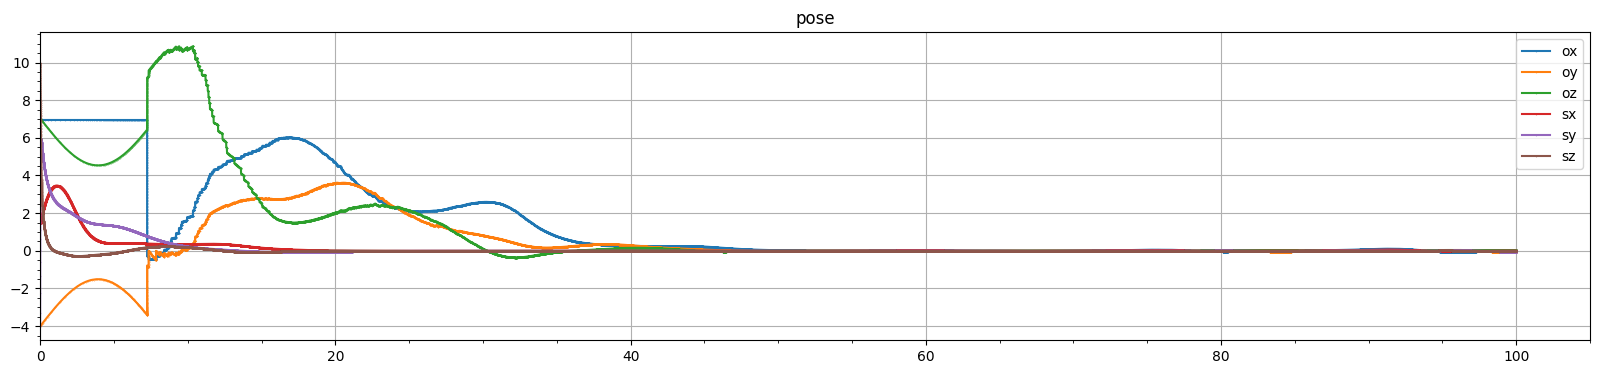

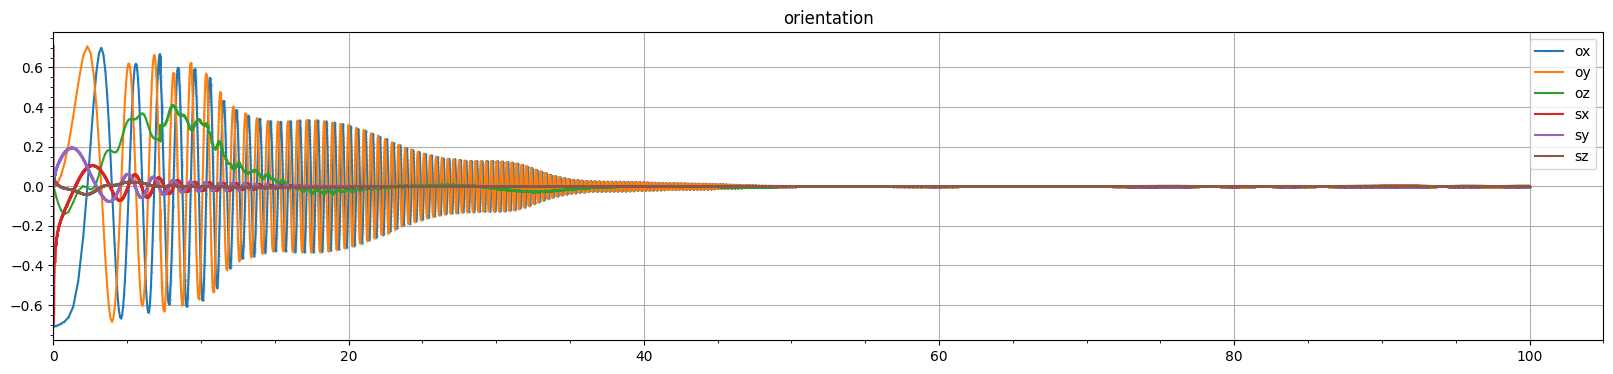

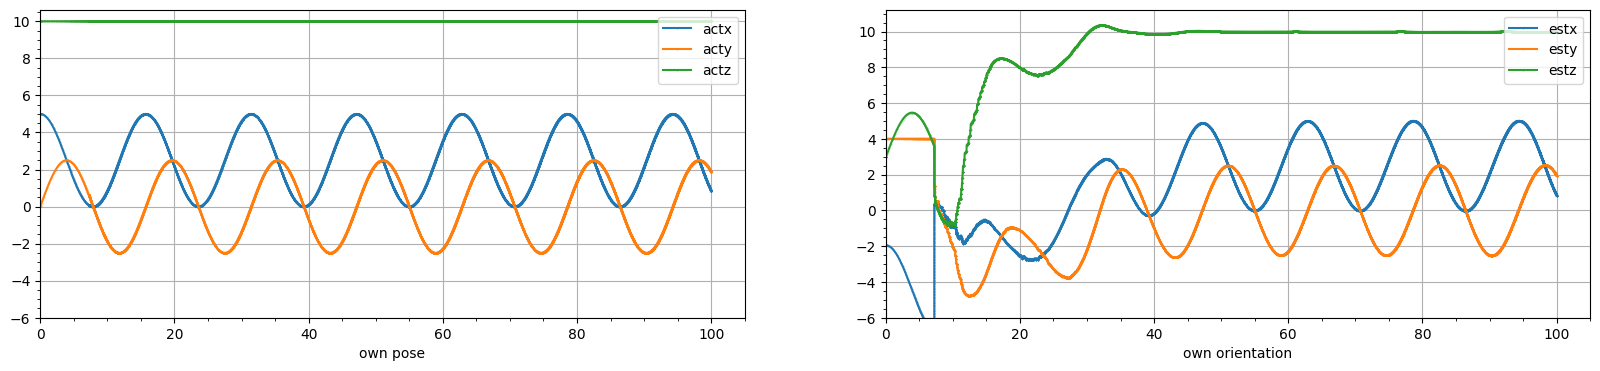

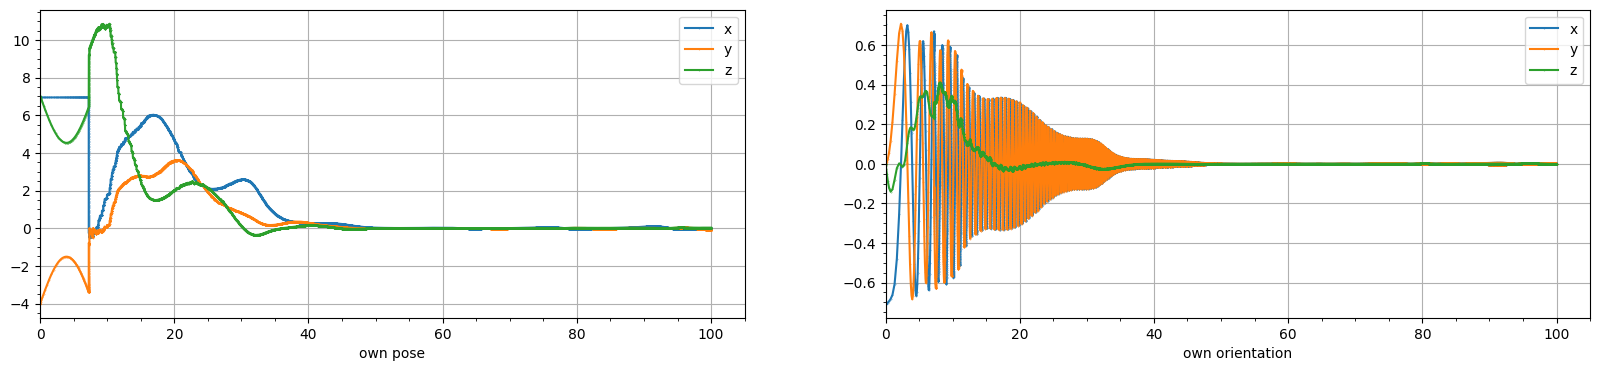

In [ ]:
figsize = (20, 4)
figure= plt.figure(figsize=figsize)

plot_est_p = []
plot_act_p = []
for t, solution in zip(solt, soly):
    own_sol_est_R = solution[9:18]
    own_sol_est_p_bar = solution[18:21]
    p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
    p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(own_sol_est_R).reshape((3,3)))), own_sol_est_p_bar)
    plot_est_p.append(p_temp.tolist())
    plot_act_p.append(p.tolist())
scipy_plot_est_p = []
scipy_plot_act_p = []
for t, rotation, p_bar_hat in zip(sol_t, sol_est_R, sol_est_p_bar):
    p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
    p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(rotation).reshape((3,3)))), p_bar_hat)
    scipy_plot_est_p.append(p_temp.tolist())
    scipy_plot_act_p.append(p.tolist())
plt.plot(solt, np.array(plot_act_p)-np.array(plot_est_p), label=["ox", "oy", "oz"], marker='o', markersize=0.2)
plt.plot(sol_t, np.array(scipy_plot_act_p)-np.array(scipy_plot_est_p), label=["sx", "sy", "sz"], marker='o', markersize=0.2)
plt.legend(loc="upper right")
plt.title("pose")
plt.grid()
plt.xlim(0)
plt.minorticks_on()
plt.show()

figure= plt.figure(figsize=figsize)

plot_err_lambda_bar = []
plot_act_lambda_bar = []
plot_est_lambda_bar = []
for idx, (t, solution) in enumerate(zip(solt, soly)):
    own_sol_R = solution[:9]
    own_sol_est_R = solution[9:18]
    err = np.matmul(np.linalg.inv(np.array(own_sol_est_R).reshape((3,3))), np.array(own_sol_R).reshape((3,3)))
    est = ScipyRot.from_matrix(np.array(own_sol_est_R).reshape((3,3)))
    act = ScipyRot.from_matrix(np.array(own_sol_R).reshape((3,3)))
    err = ScipyRot.from_matrix(err)
    err = err.as_quat().tolist()
    est = est.as_quat().tolist()
    act = act.as_quat().tolist()
    plot_err_lambda_bar.append(err)
    plot_est_lambda_bar.append(est)
    plot_act_lambda_bar.append(act)

scipy_plot_err_lambda_bar = []
scipy_plot_act_lambda_bar = []
scipy_plot_est_lambda_bar = []
for idx, (t, est_rotation, rotation) in enumerate(zip(sol_t, sol_est_R, sol_R)):
    err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
    est = ScipyRot.from_matrix(np.array(est_rotation).reshape((3,3)))
    act = ScipyRot.from_matrix(np.array(rotation).reshape((3,3)))
    err = ScipyRot.from_matrix(err)
    err = err.as_quat().tolist()
    est = est.as_quat().tolist()
    act = act.as_quat().tolist()
    scipy_plot_err_lambda_bar.append(err)
    scipy_plot_est_lambda_bar.append(est)
    scipy_plot_act_lambda_bar.append(act)

plt.plot(solt, np.array(plot_err_lambda_bar)[:,0:3], label=["ox", "oy", "oz"], marker='o', markersize=0.2)
plt.plot(sol_t, np.array(scipy_plot_err_lambda_bar)[:,0:3], label=["sx", "sy", "sz"], marker='o', markersize=0.2)
plt.legend(loc="upper right")
plt.title("orientation")
plt.grid()
plt.xlim(0)
plt.minorticks_on()
plt.show()

figure, ax = plt.subplots(1,2, figsize=figsize)

ax[0].plot(solt, np.array(plot_act_p), label=["actx", "acty", "actz"], marker='o', markersize=0.2)
ax[0].legend(loc="upper right")
ax[0].set_xlabel("own pose")
ax[0].grid()
ax[0].set_xlim(0)
ax[0].set_ylim(-6)
ax[0].minorticks_on()

ax[1].plot(solt, np.array(plot_est_p), label=["estx", "esty", "estz"], marker='o', markersize=0.2)
ax[1].legend(loc="upper right")
ax[1].set_xlabel("own orientation")
ax[1].grid()
ax[1].set_xlim(0)
ax[1].set_ylim(-6)
ax[1].minorticks_on()
plt.show()


figure, ax = plt.subplots(1,2, figsize=figsize)

ax[0].plot(solt, np.array(plot_act_p)-np.array(plot_est_p), label=["x", "y", "z"], marker='o', markersize=0.2)
ax[0].legend(loc="upper right")
ax[0].set_xlabel("own pose")
ax[0].grid()
ax[0].set_xlim(0)
ax[0].minorticks_on()

ax[1].plot(solt, np.array(plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"], marker='o', markersize=0.2)
ax[1].legend(loc="upper right")
ax[1].set_xlabel("own orientation")
ax[1].grid()
ax[1].set_xlim(0)
ax[1].minorticks_on()
plt.show()


In [ ]:
# import pandas as pd
# df = pd.DataFrame(np.array(soly))
# df.to_csv('/home/annika/ITRL/kth_thesis/ricatti_solution_own_rk45_sim5_without_noise.txt', sep='\t', index=False, header=False)

In [ ]:
dttemp = []
for idxtemp, ttemp in enumerate(solt):
    if idxtemp < len(solt)-1:
        dttemp.append(solt[idxtemp+1] - solt[idxtemp])

[2.0351e+04 6.1000e+01 9.0000e+00 4.0000e+00 3.0000e+00 3.0000e+00
 3.0000e+00 0.0000e+00 2.0000e+00 3.0000e+00]
[3.25790671e-06 3.38360394e-02 6.76688210e-02 1.01501603e-01
 1.35334384e-01 1.69167166e-01 2.02999947e-01 2.36832729e-01
 2.70665510e-01 3.04498292e-01 3.38331073e-01]


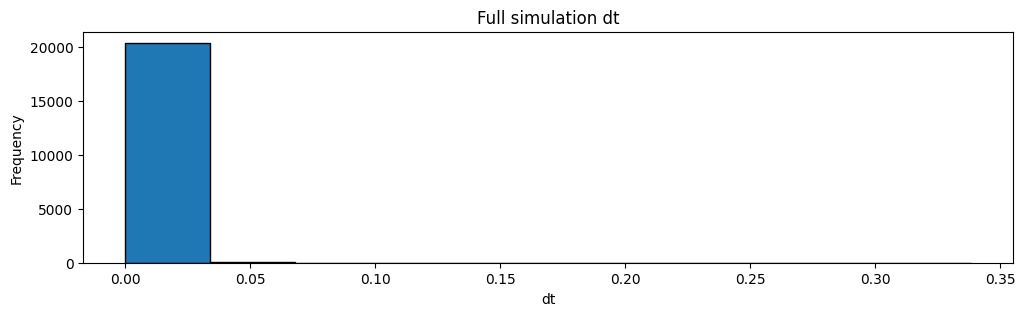

[4.679e+03 1.052e+04 4.482e+03 6.680e+02 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e+00]
[3.25790671e-06 2.90423011e-03 5.80520232e-03 8.70617453e-03
 1.16071467e-02 1.45081189e-02 1.74090911e-02 2.03100634e-02
 2.32110356e-02 2.61120078e-02 2.90129800e-02]


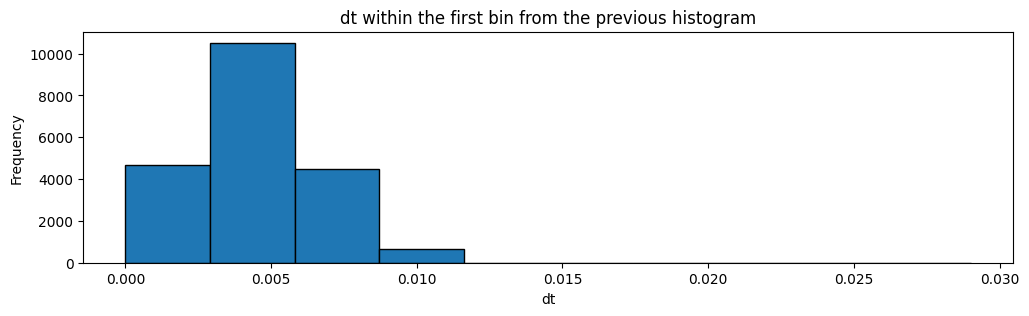

In [ ]:
num_bins = 10
figure= plt.figure(figsize=(12,3))
counts, bins, patches = plt.hist(dttemp, bins=num_bins, edgecolor='black')
plt.xlabel('dt')
plt.ylabel('Frequency')
plt.title('Full simulation dt')
print(counts)
print(bins)
# Show plot
plt.show()
bin1 = []
for ttemp in dttemp:
    if ttemp < bins[1]:
        bin1.append(ttemp)

num_bins = 10
figure= plt.figure(figsize=(12,3))
counts2, bins2, patches = plt.hist(bin1, bins=num_bins, edgecolor='black')
plt.xlabel('dt')
plt.ylabel('Frequency')
plt.title('dt within the first bin from the previous histogram')
print(counts2)
print(bins2)
# Show plot
plt.show()

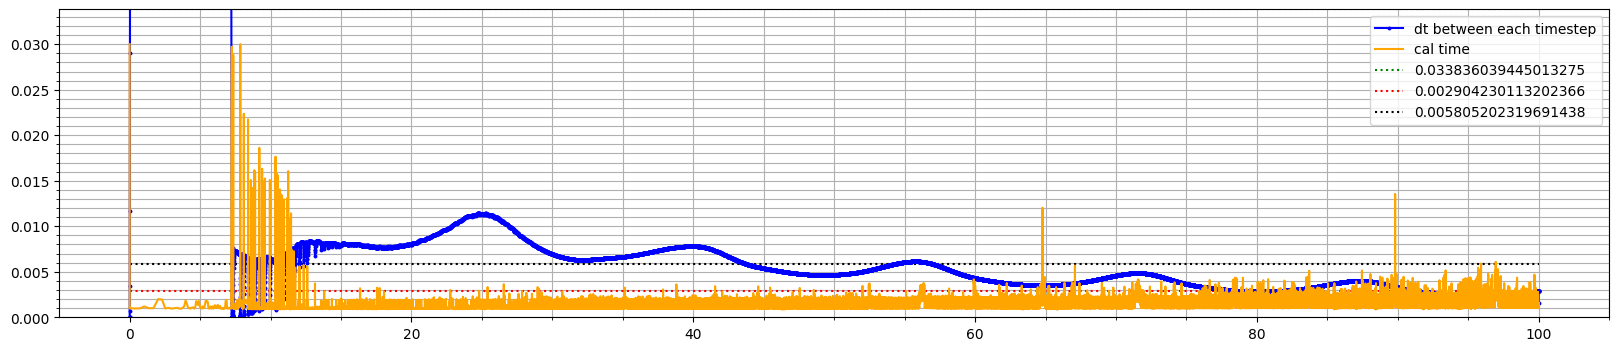

lowest dt:  3.2579067132942896e-06


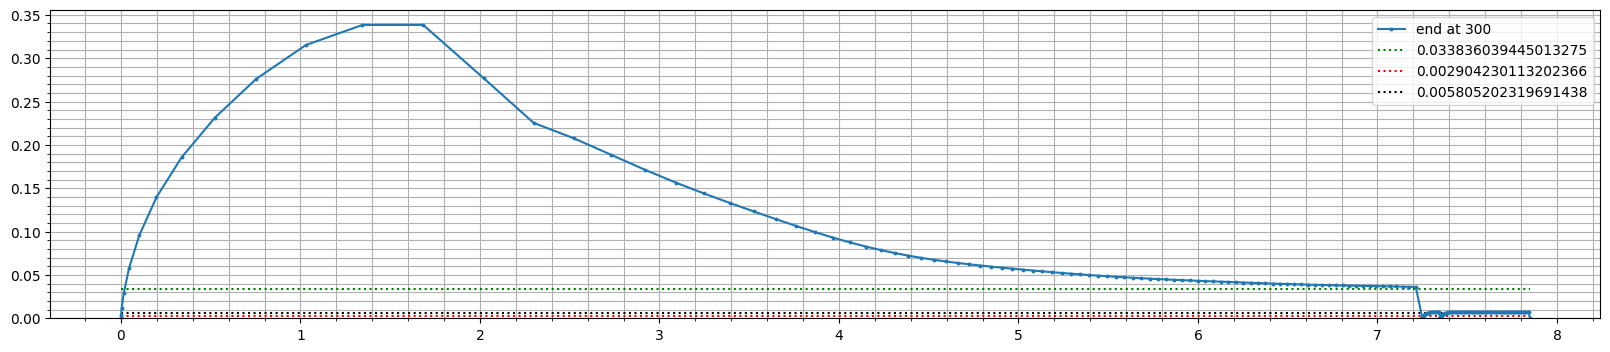

In [ ]:
figsize = (20,4)
figure = plt.figure(figsize=figsize)
plt.plot(solt[:-1], dttemp, color="blue", marker='o', markersize=1.8, label="dt between each timestep")
# plt.plot(solt, np.array(plot_act_p)-np.array(plot_est_p), label=["x", "y", "z"], marker='o', markersize=0.2)
plt.hlines(y=bins[1], xmin=0, xmax=time[1], color='green', linestyles='dotted', label=bins[1])
plt.hlines(y=bins2[1], xmin=0, xmax=time[1], color='red', linestyles='dotted', label=bins2[1])
plt.hlines(y=bins2[2], xmin=0, xmax=time[1], color='black', linestyles='dotted', label=bins2[2])
plt.plot(solt, caltime, color="orange", label="cal time")
plt.minorticks_on()
plt.ylim(0, bins[1])
plt.legend()
plt.grid(which='both')
plt.show()

figure = plt.figure(figsize=figsize)
end = 300
print("lowest dt: ", min(dttemp))
plt.plot(solt[:end], dttemp[:end], label="end at " + str(end), marker='o', markersize=1.8)
plt.hlines(y=bins[1], xmin=0, xmax=solt[end], color='green', linestyles='dotted', label=bins[1])
plt.hlines(y=bins2[1], xmin=0, xmax=solt[end], color='red', linestyles='dotted', label=bins2[1])
plt.hlines(y=bins2[2], xmin=0, xmax=solt[end], color='black', linestyles='dotted', label=bins2[2])
plt.minorticks_on()
plt.ylim(0)
plt.legend()
plt.grid(which='both')
plt.show()

